In [84]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Aug 21 14:52:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    35W /  70W |   4906MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [85]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


####라이브러리

In [86]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import time

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [87]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 10
learning_rate = 0.001
num_epochs = 15

1. 데이터 정의

#### A. Datasets and Preprocessing

In [88]:
#image transformation
image_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((132, 132)),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])                 
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((132, 132)),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

####B. DataLoader

In [89]:
os.getcwd()

'/content'

In [90]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [91]:
#The Path in which the data exists
os.listdir('./gdrive/MyDrive/ColabNotebooks/data/')

['tumor']

In [92]:
dataset = 'tumor'

train_directory = './gdrive/MyDrive/ColabNotebooks/data/tumor/Training'

test_directory = './gdrive/MyDrive/ColabNotebooks/data/tumor/Testing'

#batch size
batch_size = 32

#Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

data = {
    'train': datasets.ImageFolder(root = train_directory, transform = image_transforms['train']),
    'test': datasets.ImageFolder(root = test_directory, transform = image_transforms['test'])
}
#Mapping of the indices to the class names, in order to see the output classes of the test dataset images.
idx_to_class = {v: x for x, v in data['train'].class_to_idx.items()}
print(idx_to_class)

#Size of each datasets.
train_data_size = len(data['train'])
test_data_size = len(data['test'])

4
{0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}


In [93]:
#The Size for each class in the train dataset
print(len(os.listdir(train_directory + '/glioma_tumor')))
print(len(os.listdir(train_directory + '/meningioma_tumor')))
print(len(os.listdir(train_directory + '/no_tumor')))
print(len(os.listdir(train_directory + '/pituitary_tumor')))

826
822
395
827


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


glioma_tumor glioma_tumor pituitary_tumor glioma_tumor


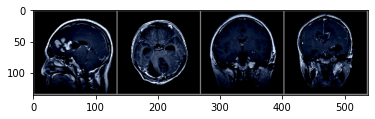

In [94]:
train_data_loader = DataLoader(data['train'], batch_size = batch_size, shuffle = True)
test_data_loader = DataLoader(data['test'], batch_size = batch_size, shuffle = False)

def showimage(img):
  img = img / 2 + 0.5
  numpy_image = img.numpy()
  plt.imshow(np.transpose(numpy_image, (1, 2, 0)))

trainloader_1 = DataLoader(data['train'], batch_size = 4, shuffle =True)
dataiter = iter(trainloader_1)
images, labels = dataiter.next()

showimage(torchvision.utils.make_grid(images))
print(' '.join('%5s' % list(idx_to_class.values())[labels[j]] for j in range(4)))

In [95]:
del trainloader_1

In [96]:
#checking the size of the datasets
train_data_size, test_data_size

(2870, 394)

# **2. 모델**

####My Model implementation take

In [97]:
resnet_model = models.resnet50(pretrained=True)
for param in resnet_model.parameters():
  param.requires_grad = True

#get the input of the fully connected layer
n_inputs = resnet_model.fc.in_features

resnet_model.fc = nn.Sequential(nn.Linear(n_inputs, 64),
                                nn.ReLU(),
                                nn.Dropout(p=0.5),
                                nn.Linear(64, 64),
                                nn.ReLU(),
                                nn.Dropout(p=0.5),
                                nn.Linear(64, num_classes),
                                nn.LogSoftmax(dim=1))

for name, child in resnet_model.named_children():
  for name2, params in child.named_parameters():
    params.requires_grad = True

resnet_model.to(device)

resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [98]:
#Intialize Criterion and Optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001)

epochs = 25

In [99]:
iter(train_data_loader).__next__()

[tensor([[[[-2.1104, -2.1104, -2.1104,  ..., -2.1104, -2.1008, -2.1179],
           [-2.0611, -2.0611, -2.0611,  ..., -2.0611, -2.0440, -2.0782],
           [-2.0248, -1.9980, -2.0152,  ..., -2.0316, -2.0328, -2.0199],
           ...,
           [-2.0210, -1.9484, -1.9460,  ..., -1.9426, -1.9519, -1.9877],
           [-2.0676, -2.0385, -2.0611,  ..., -2.0556, -2.0440, -2.0632],
           [-2.1125, -2.1179, -2.1083,  ..., -2.1179, -2.1179, -2.1125]],
 
          [[-2.0280, -2.0280, -2.0280,  ..., -2.0280, -2.0182, -2.0357],
           [-1.9776, -1.9776, -1.9776,  ..., -1.9776, -1.9601, -1.9951],
           [-1.9405, -1.9132, -1.9307,  ..., -1.9475, -1.9487, -1.9355],
           ...,
           [-1.9366, -1.8625, -1.8600,  ..., -1.8565, -1.8660, -1.9026],
           [-1.9843, -1.9545, -1.9776,  ..., -1.9721, -1.9601, -1.9797],
           [-2.0302, -2.0357, -2.0259,  ..., -2.0357, -2.0357, -2.0302]],
 
          [[-1.7968, -1.7968, -1.7968,  ..., -1.7968, -1.7870, -1.8044],
           [-

In [100]:
def train(model, loss_criterion, optimizer, epochs):
  start = time.time()           #시작 time 재기!
  history = []
  best_acc = 0.0                #Best Accuracy Value

  for epoch in range(epochs):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, epochs))

    #Model to Training Mode!
    model.train()

    #Initialize Loss and Accuracy
    train_loss = 0.0
    train_acc = 0.0 

    for i, (inputs, labels) in enumerate(train_data_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      #Forward Pass
      outputs = model(inputs)

      #Loss Computation
      loss = loss_criterion(outputs, labels)

      #Back Propagation
      loss.backward()

      #Update the parameters
      optimizer.step()

      train_loss += loss.item() * inputs.size(0)
      
      #Computing the accuracy(다소 헷갈리는 파트, 다시 확인!!!)
      ret, predictions = torch.max(outputs.data, 1)
      correct_counts = predictions.eq(labels.data.view_as(predictions))

      acc = torch.mean(correct_counts.type(torch.FloatTensor))

      train_acc += acc.item() * inputs.size(0)

      if i % 50 == 0 and i != 0:
        print("Batch Number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

    avg_train_loss = train_loss / train_data_size
    avg_train_acc = train_acc / train_data_size
    history.append([avg_train_loss, avg_train_acc])

    epoch_end = time.time()

    print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, epoch_end-epoch_start))

    if best_acc < avg_train_acc:
      best_acc = avg_train_acc
      torch.save(model, dataset + '_model_' + str(epoch))


  return model, history




In [101]:
num_epochs = 10
train_model, history = train(resnet_model, criterion, optimizer, num_epochs)

#Saving model
torch.save(history, dataset + '_history.pt')

Epoch: 1/10
Batch Number: 050, Training: Loss: 0.8473, Accuracy: 0.6250
Epoch : 000, Training: Loss: 1.0058, Accuracy: 56.0976%, Time: 33.3611s
Epoch: 2/10
Batch Number: 050, Training: Loss: 0.8118, Accuracy: 0.6250
Epoch : 001, Training: Loss: 0.7616, Accuracy: 69.6167%, Time: 33.1014s
Epoch: 3/10
Batch Number: 050, Training: Loss: 0.9174, Accuracy: 0.6875
Epoch : 002, Training: Loss: 0.7012, Accuracy: 73.2753%, Time: 33.0817s
Epoch: 4/10
Batch Number: 050, Training: Loss: 0.6208, Accuracy: 0.7500
Epoch : 003, Training: Loss: 0.5878, Accuracy: 77.3519%, Time: 32.9542s
Epoch: 5/10
Batch Number: 050, Training: Loss: 0.3725, Accuracy: 0.8750
Epoch : 004, Training: Loss: 0.5273, Accuracy: 79.9652%, Time: 33.1719s
Epoch: 6/10
Batch Number: 050, Training: Loss: 0.5098, Accuracy: 0.8438
Epoch : 005, Training: Loss: 0.4820, Accuracy: 82.0906%, Time: 33.3037s
Epoch: 7/10
Batch Number: 050, Training: Loss: 0.4861, Accuracy: 0.8750
Epoch : 006, Training: Loss: 0.5055, Accuracy: 82.9965%, Time: 3

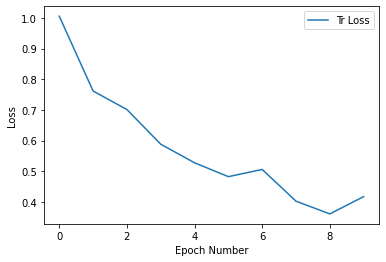

In [102]:
#Loss Examination Process
history = np.array(history)
plt.plot(history[:,0])
plt.legend(['Tr Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.savefig(dataset+'_loss_curve.png')
plt.show()

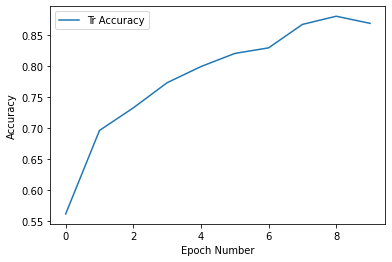

In [103]:
#Accuracy Examination Process
history = np.array(history)
plt.plot(history[:,1])
plt.legend(['Tr Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.savefig(dataset + '_accuracy_curve.png')
plt.show()

In [104]:
# Test the model
resnet_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 52.28426395939086 %
